## Yield Optimization via Hybrid ML-Bayesian for Multidimensional Feature Space

In [2]:
import numpy as np
import pandas as pd

import tensorflow
import autokeras as ak

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from IPython.display import clear_output



In [3]:
class TrainingPlot(tensorflow.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('mean_squared_error'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_mean_squared_error'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            #plt.figure()
            #subplot(nrows, ncols, plot_number) 
            plt.figure(figsize=(15,6))
            plt.subplot(121)
            plt.title("Training Loss [Epoch {}]".format(epoch))
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss")
            plt.legend()
            
            plt.subplot(122)
            plt.title("Training Accuracy [Epoch {}]".format(epoch))
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.xlabel("Epoch #")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

C:\Users\MajidMortazavi\AppData\Local\Temp\ipykernel_28560\2915248382.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


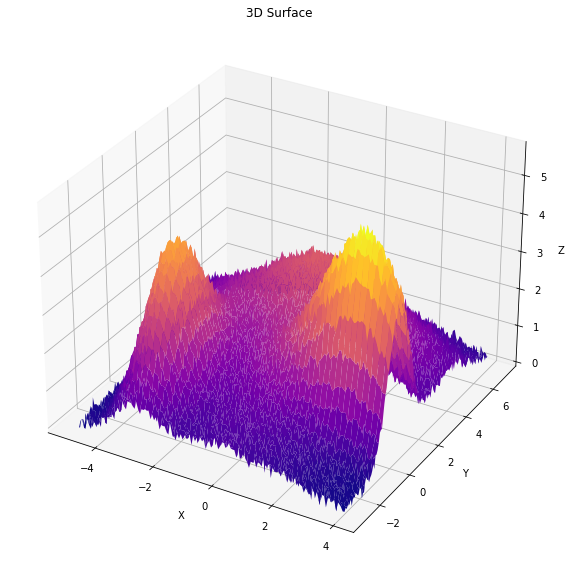

In [9]:
from mpl_toolkits.mplot3d import Axes3D


def generate_3d_data(xmin, xmax, ymin, ymax, line_mesh):

    # The two-dimensional domain of the fit.
    xmin, xmax, nx = xmin, xmax, line_mesh
    ymin, ymax, ny = ymin, ymax, line_mesh
    x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(x, y)

    # Our function to fit is going to be a sum of two-dimensional Gaussians
    def gaussian(x, y, x0, y0, xalpha, yalpha, A):
        return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

    # A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
    gprms = [(0, 2, 2.5, 5.4, 1.5),
            (-1, 4, 6, 2.5, 1.8),
            (-3, -0.5, 1, 2, 4),
            (3, 0.5, 2, 1, 5)
            ]

    # Standard deviation of normally-distributed noise to add in generating
    # our test function to fit.
    noise_sigma = 0.1

    # The function to be fit is Z.
    Z = np.zeros(X.shape)
    for p in gprms:
        Z += gaussian(X, Y, *p)
    Z += noise_sigma * np.random.randn(*Z.shape)

    return X, Y, Z

X, Y, Z = generate_3d_data(-5, 4, -3, 7, 150)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface')
plt.show();

## Data

In [12]:
df = pd.DataFrame(columns=['X','Y','Z'], dtype=float)

In [13]:
df['X'] = X.reshape(-1, )
df['Y'] = Y.reshape(-1, ) 
df['Z'] = Z.reshape(-1, ) 

df['X'] = df['X'].astype(float)
df['Y'] = df['Y'].astype(float)
df['Z'] = df['Z'].astype(float)

In [14]:
print(df.head())

          X    Y         Z
0 -5.000000 -3.0 -0.101702
1 -4.939597 -3.0  0.099565
2 -4.879195 -3.0  0.167207
3 -4.818792 -3.0 -0.051087
4 -4.758389 -3.0  0.057329


In [15]:
df.describe()

,X,Y,Z
count,22500.000000,22500.000000,22500.000000
mean,-0.500000,2.000000,1.721685
std,2.615513,2.906126,1.021505
min,-5.000000,-3.000000,-0.225138
25%,-2.765101,-0.516779,0.946387
50%,-0.500000,2.000000,1.585844
75%,1.765101,4.516779,2.357473
max,4.000000,7.000000,5.751128


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       22500 non-null  float64
 1   Y       22500 non-null  float64
 2   Z       22500 non-null  float64
dtypes: float64(3)
memory usage: 527.5 KB


## Prediction algorithm

In [17]:
# normalize the input data
x = df[['X', "Y"]].values
y = df['Z'].values

X_norm = x #(X - X.mean()) / X.std()
y_norm = y #(y - y.mean()) / y.std()


x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

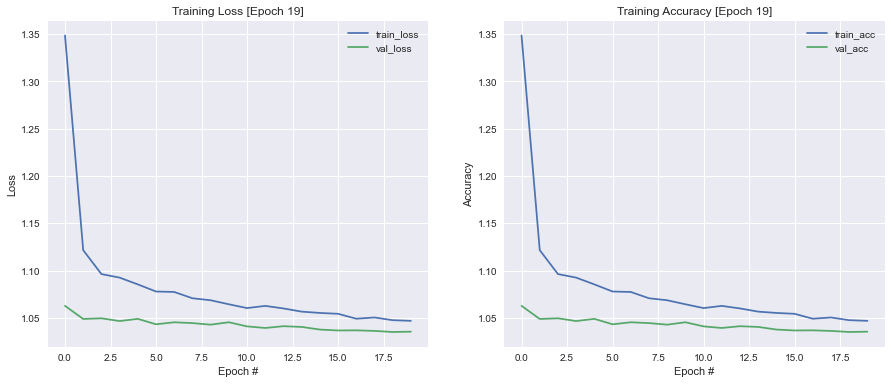

563/563 [==============================] - 2s 3ms/step - loss: 1.0470 - mean_squared_error: 1.0470 - val_loss: 1.0356 - val_mean_squared_error: 1.0356
INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets


In [19]:
# define the search
search = ak.StructuredDataRegressor(max_trials=5)

# perform the search
history =  search.fit(x=x_train, 
                      y=y_train.reshape(-1,1),
                      validation_data= (x_test, y_test.reshape(-1,1)),
                      callbacks=[plot_losses], 
                      epochs = 20,
                      verbose=1)

In [20]:
loss, acc = search.evaluate(x_test, y_test, verbose=1)
print('Accuracy: %.4f' % acc)

141/141 [==============================] - 0s 2ms/step - loss: 1.0356 - mean_squared_error: 1.0356
Accuracy: 1.0356


In [21]:
# get the best performing model
model = search.export_model()

# summarize the loaded model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 2)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [22]:
from sklearn.metrics import r2_score
r2_score(y_test, model.predict(x_test))

0.004535987718996215

In [23]:
tp_indx = 4
print(f"real value: {y_test[tp_indx]}, model predicted: {model.predict(x_test[tp_indx].reshape(1,-1))}")

real value: 0.7360569786396611, model predicted: [[1.6837047]]


## Bayesian Optimization
- https://github.com/fmfn/BayesianOptimization
- https://towardsdatascience.com/bayesian-optimization-with-python-85c66df711ec

As you iterate over and over, the algorithm balances its needs of exploration and exploitation taking into account what it knows about the target function. At each step a Gaussian Process is fitted to the known samples (points previously explored), and the posterior distribution, combined with a exploration strategy (such as UCB (Upper Confidence Bound), or EI (Expected Improvement)), are used to determine the next point that should be explored

We will use the Upper Confidence Bound (UCB) as our utility function. It has the free parameter \(\kappa\) which control the balance between exploration and exploitation; we will set \(\kappa=5\) which, in this case, makes the algorithm quite bold. Additionally we will use the cubic correlation in our Gaussian Process.

Exploitation vs Exploration:
- https://github.com/fmfn/BayesianOptimization/blob/master/examples/exploitation_vs_exploration.ipynb

Visualization:
- https://philipperemy.github.io/visualization/

Design of Experiments
- https://danmackinlay.name/notebook/design_of_experiments.html


In [24]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    # acq.set_xlim((-2, 2))
    # axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    # acq.set_xlim((-2, 2))
    # acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [25]:
def wrapper(x, *args) -> float:
    
    network_input = x
    network_output = model.predict(network_input, *args)
    bo = float(network_output)
    print(f"bo: {bo}")#
    
    if (bo > -1) & (bo < 10):
        return bo
    
    else:
        return 10000000

In [36]:
pbounds = {'x': np.array([[-5, 3.], [-3, 7]])}
bo = BayesianOptimization(wrapper, pbounds, verbose=2)
bo.maximize(init_points=2, n_iter=2, acq='ucb', kappa=2)


|   iter    |  target   |     x     |
-------------------------------------


ValueError: Output size (1,) is not compatible with broadcast dimensions of inputs (2,).

In [39]:
def bo_run(x, y, wrapper, pbounds, n_iter=10, kappa=5, xi=None, random_state=None):

    bo = BayesianOptimization(wrapper, pbounds, verbose=2)

    bo.maximize(init_points=2, n_iter=n_iter, acq='ucb', kappa=kappa)
    # plot_gp(bo, x, y);

    utility = UtilityFunction(kind="ucb", kappa=kappa, xi=0)
    next_point_to_probe = bo.suggest(utility)

    print(f"Next Point to Probe: {next_point_to_probe}")
    print(f"Optimal Point: {bo.max}")


In [41]:
pbounds = {'x': (-5, 7)}

bo_run(x, y, wrapper, pbounds, n_iter=30, kappa=5, xi=None, random_state=None)

|   iter    |  target   |     x     |
-------------------------------------


IndexError: list index out of range